# Building Data Genome - Modelling

---


## Installations and Setting up

---

In [5]:
#Installations

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import warnings
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')
import gc
import geopandas as gpd
from shapely.geometry import Point, Polygon

#Modelling
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_colwidth', None)

### To use working directory in Google Drive:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!pwd
#!ls '/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/'

### To use local directory:

In [2]:
#Import csv data into dataframes

#file path:
file_path = 'D:/building-data-genome/project_data/'

#Energy related
df_solar = pd.read_csv(file_path + 'solar_cleaned.csv')
df_water = pd.read_csv(file_path + 'water_cleaned.csv')
df_electricity = pd.read_csv(file_path + 'electricity_cleaned.csv')
df_gas = pd.read_csv(file_path + 'gas_cleaned.csv')
df_hotwater = pd.read_csv(file_path + 'hotwater_cleaned.csv')
df_irrigation = pd.read_csv(file_path + 'irrigation_cleaned.csv')
df_chilledwater = pd.read_csv(file_path + 'chilledwater_cleaned.csv')
df_steam = pd.read_csv(file_path + 'steam_cleaned.csv')

#Metadata
df_metadata = pd.read_csv(file_path + 'metadata.csv')

#Weather
df_weather = pd.read_csv(file_path + 'weather.csv')

### Reformat and merge data

In [3]:
# Keep only buildings of the top 5 regions in our dataset:
df_metadata = df_metadata[df_metadata["timezone"].isin(["US/Eastern", "US/Central", "Europe/London", "US/Mountain", "US/Pacific"])]


# Reformat the meters dataframes first

def melt_meter_dataframes (df, meter_name):
  #timestamp into datetime
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  # Melt the DataFrame: columns become rows under 'building_id', and their values go under 'meter_reading'
  df = df.melt(
      id_vars=["timestamp"],              # Columns to keep as is
      var_name="building_id",             # Name for the new column with former column names
      value_name="meter_reading"          # Name for the new column with values from the original DataFrame
      )

  # Add the 'meter' column
  df["meter"] = meter_name

  # Rearrange columns for clarity
  df = df[["timestamp", "building_id", "meter", "meter_reading"]]

  return df

df_electricity = melt_meter_dataframes(df_electricity, "electricity")
df_gas = melt_meter_dataframes(df_gas, "gas")
df_hotwater = melt_meter_dataframes(df_hotwater, "hotwater")
df_chilledwater = melt_meter_dataframes(df_chilledwater, "chilledwater")
df_steam = melt_meter_dataframes(df_steam, "steam")
df_water = melt_meter_dataframes(df_water, "water")
df_irrigation = melt_meter_dataframes(df_irrigation, "irrigation")
df_solar = melt_meter_dataframes(df_solar, "solar")


# Function to reduce the DF size ( https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Reduce memory
df_metadata = reduce_mem_usage(df_metadata)
gc.collect()

# Concatenate all meters data and then merge it with metadata

# Concatenate all the meter dataframes
meters = pd.concat([df_electricity, df_gas, df_hotwater, df_chilledwater, df_steam, df_water, df_irrigation, df_solar])
meters = reduce_mem_usage(meters)
gc.collect()

# Features from buildings metadata and weather dataset to add to meters dataset 
######### WE ADD MORE FEATURES THAN IN THE EDA ###########
buildings_sel = df_metadata[["building_id","site_id","primaryspaceusage","timezone", 'sqm', 'occupants', 'yearbuilt']]
df_weather_2 = df_weather[["timestamp", "site_id", "airTemperature", "seaLvlPressure","windSpeed"]]

# Join the datasets: meter reading + building metadata
dev = meters.merge(buildings_sel, on="building_id", how = "left")

# Transform timestamp to datetime object type
dev["timestamp"] = pd.to_datetime(dev["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_weather_2["timestamp"] = pd.to_datetime(df_weather_2["timestamp"], format='%Y-%m-%d %H:%M:%S')

# Merge with the weather dataset to add weather data
dev = dev.merge(df_weather_2, on=["timestamp", "site_id"], how="left")

del(meters, buildings_sel, df_metadata, df_weather_2)

Mem. usage decreased to  0.33 Mb (18.9% reduction)
Mem. usage decreased to 1838.90 Mb (10.0% reduction)


C:\Users\Vitalia\AppData\Local\Temp\ipykernel_24360\2294256471.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_2["timestamp"] = pd.to_datetime(df_weather_2["timestamp"], format='%Y-%m-%d %H:%M:%S')


In [5]:
len(dev)

53561832

In [4]:
dev.columns

Index(['timestamp', 'building_id', 'meter', 'meter_reading', 'site_id',
       'primaryspaceusage', 'timezone', 'sqm', 'occupants', 'yearbuilt',
       'airTemperature', 'seaLvlPressure', 'windSpeed'],
      dtype='object')

## Introduction

---

We had concluded in our exploratory data analysis that there are differences across regions in these cases:

1) For yearly load profiles per usage type
2) For certain daily load profiles per usage type
3) For certain daily load profiles per meter type 

We will therefore try to see if we can effectively classify the types of buildings per their load profiles as found in each region on a yearly basis and on a daily basis.

## Modelling

---

### Gaussian Mixture Model

In [ ]:
#create input data
input_df = dev[['timestamp', 'meter', 'meter_reading', "sqm", "occupants", "yearbuilt", "airTemperature", "seaLvlPressure", "windSpeed"]]
cdf = input_df.copy()

#make sure that timestamp is in datetime format
cdf['timestamp'] = pd.to_datetime(cdf['timestamp'])


### K-Means Clustering 

#### Daily load data

In [68]:
#create input data
input_df = dev[['timestamp', 'building_id','meter', 'meter_reading', "sqm", "occupants", "yearbuilt", "airTemperature", "seaLvlPressure", "windSpeed", "timezone"]]
cdf = input_df.copy()

#make sure that timestamp is in datetime format
cdf['timestamp'] = pd.to_datetime(cdf['timestamp'])

#replace with 0 if a reading is missing:
cdf['meter_reading'] = cdf['meter_reading'].fillna(0)

# Aggregating data: group by building_id and hour
cdf["hour"] = cdf["timestamp"].dt.hour
features = cdf.groupby(["timezone","building_id", "hour"])[["meter_reading"]].median().unstack(fill_value=0)

# Reset index for clustering
features = features.reset_index()
features.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in features.columns]

# Normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.iloc[:, 2:])  # Skip building_id and timezone columns


Processing timezone: Europe/London


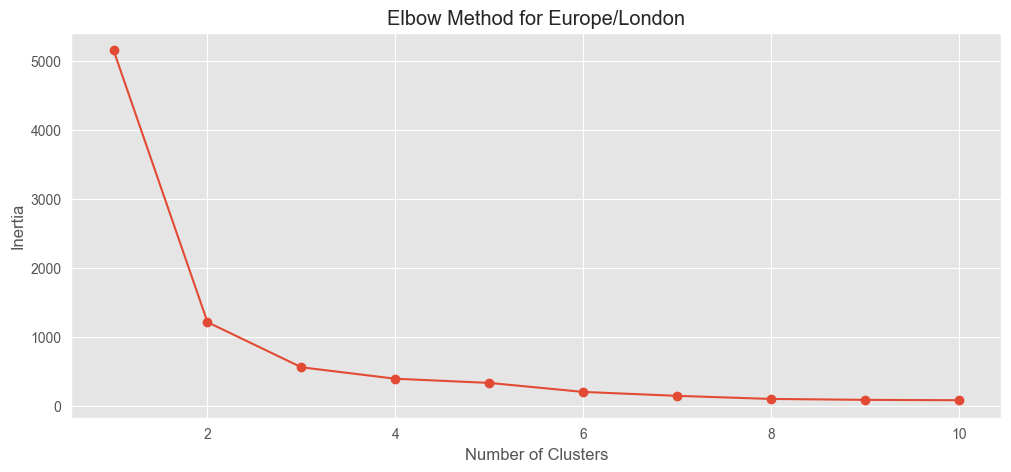

Processing timezone: US/Central


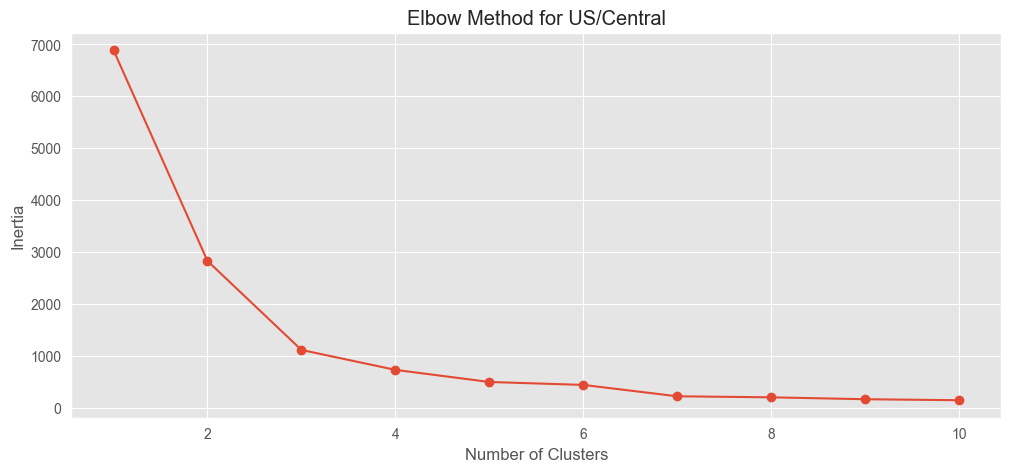

Processing timezone: US/Eastern


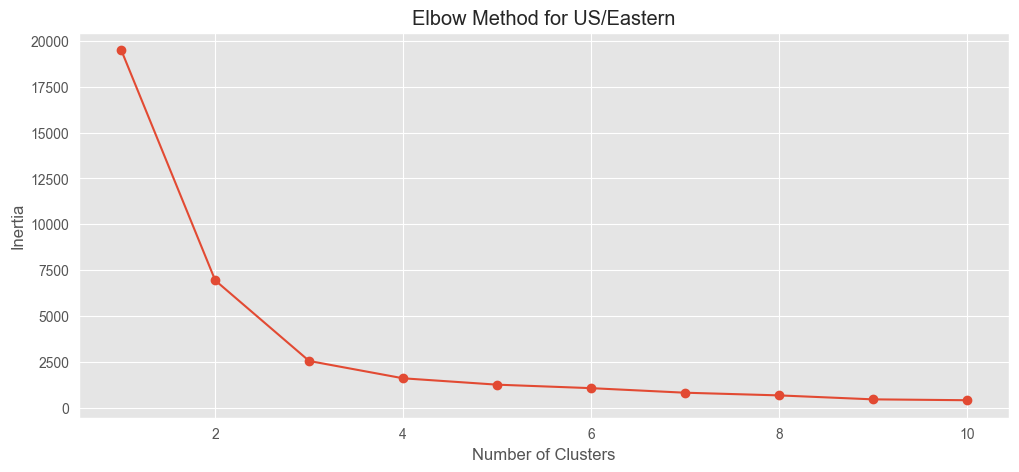

Processing timezone: US/Mountain


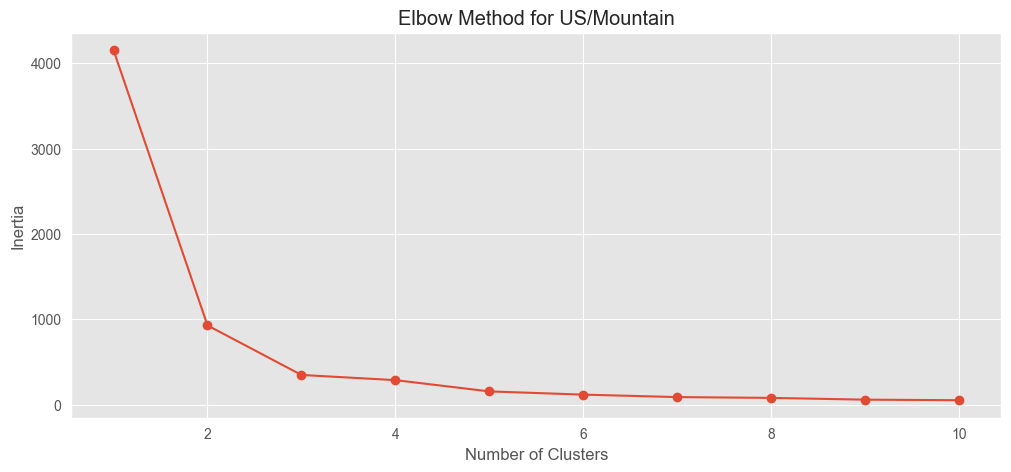

Processing timezone: US/Pacific


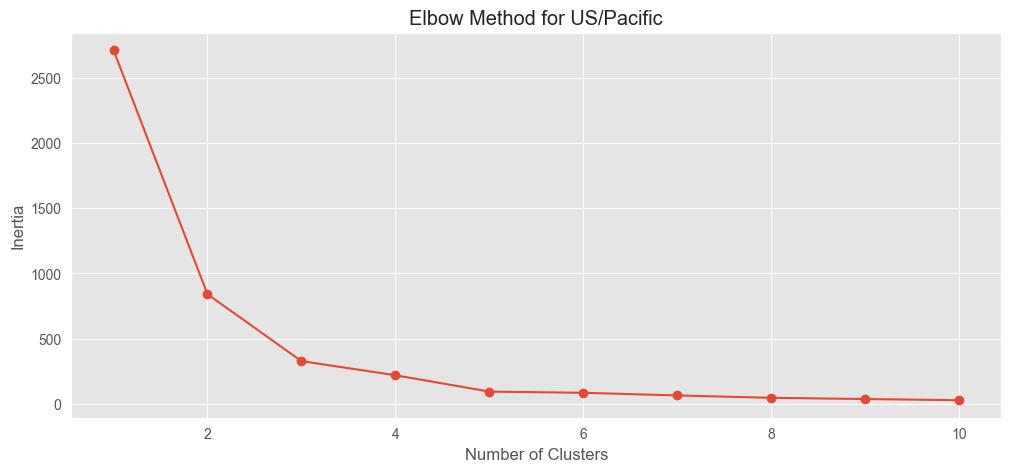

In [69]:
# Function to determine inertia for Elbow Method
def determine_elbow_inertia(features, max_clusters=10):
    inertia = []
    
    # Test cluster sizes from 1 to max_clusters
    for n_clusters in range(1, max_clusters + 1):  # Start from 1 for elbow plot
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features)
        
        # Store inertia
        inertia.append(kmeans.inertia_)
    
    return inertia

# Dictionary to store inertia results per timezone
elbow_results = {}

# Loop through each timezone
for timezone, tz_df in cdf.groupby("timezone"):
    print(f"Processing timezone: {timezone}")

    # Group data by building_id and hour for this timezone
    tz_features = tz_df.groupby(["building_id", "hour"])[["meter_reading"]].median().unstack(fill_value=0)
    tz_features = tz_features.reset_index()
    tz_features.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in tz_features.columns]

    # Normalize features (excluding building_id)
    scaler = StandardScaler()
    scaled_tz_features = scaler.fit_transform(tz_features.iloc[:, 1:])  # Skip building_id column

    # Determine inertia for elbow plot
    inertia = determine_elbow_inertia(scaled_tz_features)

    # Plot Elbow Method for this timezone
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, len(inertia) + 1), inertia, marker='o')  # Adjust range to match inertia indices
    plt.title(f"Elbow Method for {timezone}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()
    
    # Store inertia for analysis
    elbow_results[timezone] = inertia

It appears that the ideal amount of clusters in each region would be :

- US Central: 3
- US East: 3
- US Pacific: 3 or perhaps 5
- US Mountains: 2
- Europe: 3

Processing timezone: Europe/London


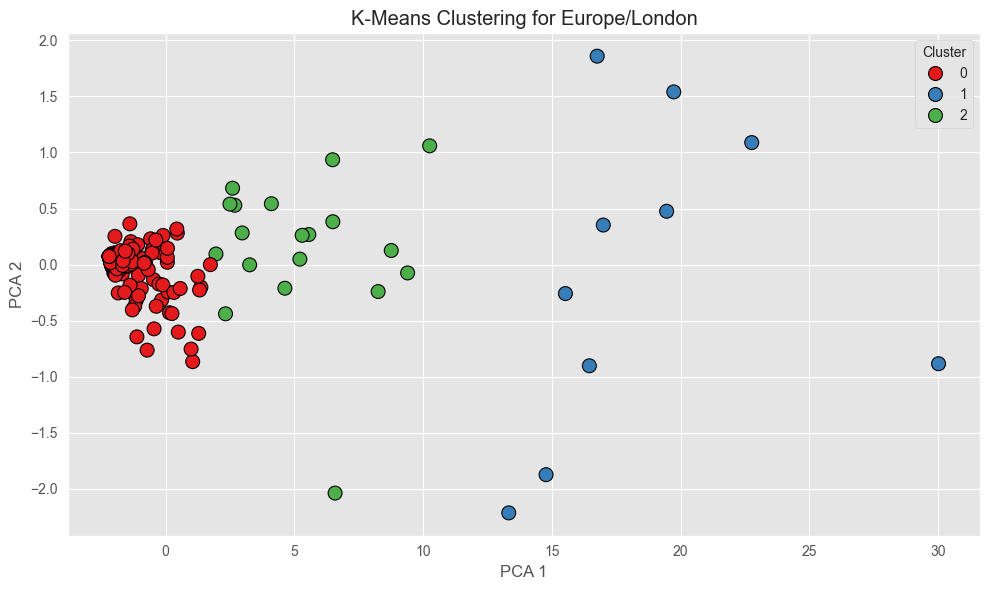

Processing timezone: US/Central


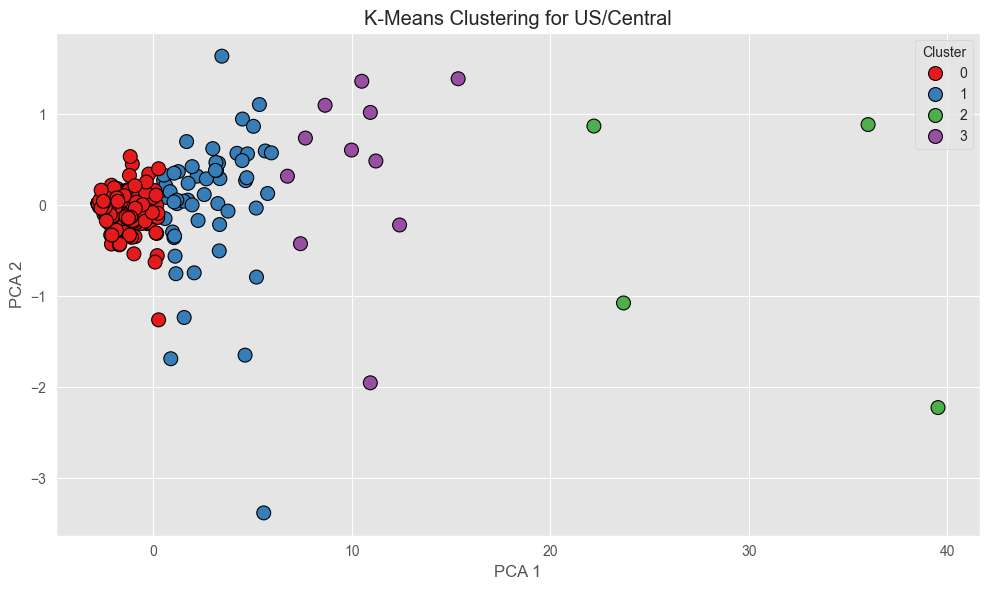

Processing timezone: US/Eastern


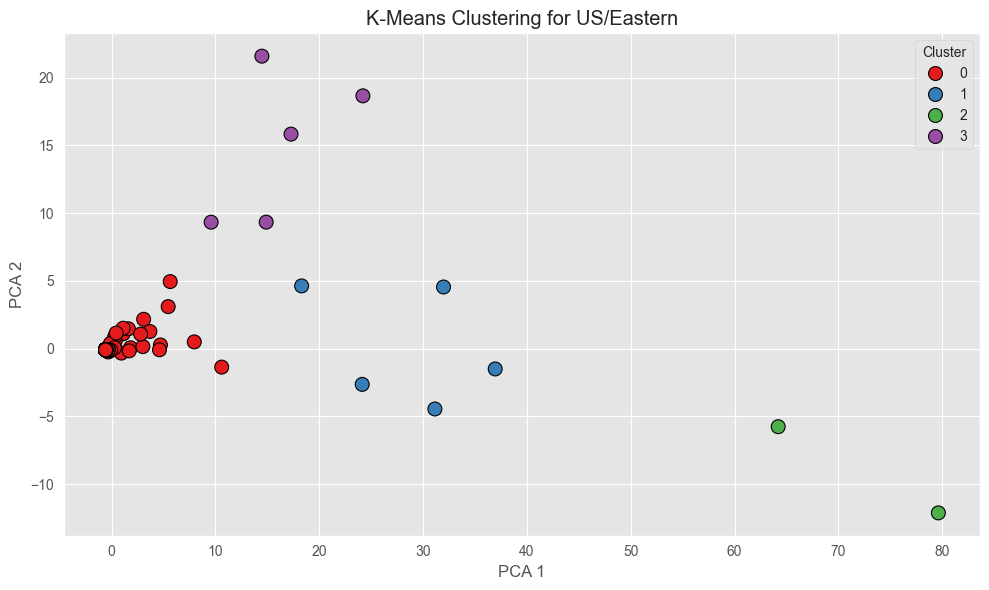

Processing timezone: US/Mountain


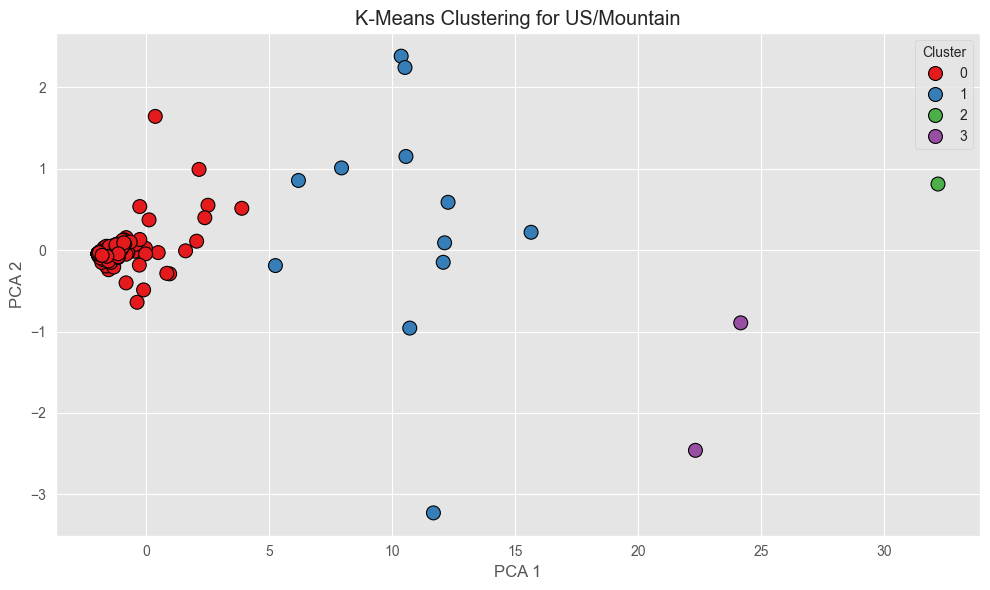

Processing timezone: US/Pacific


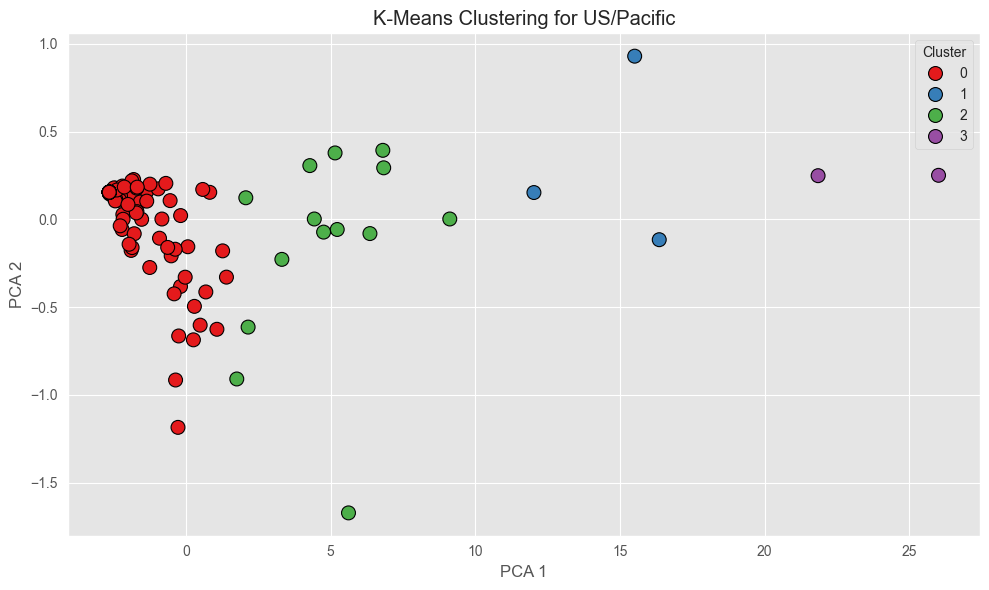

In [74]:
# Loop through each timezone
for timezone, tz_df in cdf.groupby("timezone"):
    print(f"Processing timezone: {timezone}")

    # Group data by building_id and hour for this timezone
    tz_features = tz_df.groupby(["building_id", "hour"])[["meter_reading"]].median().unstack(fill_value=0)
    tz_features = tz_features.reset_index()

    # Flatten multi-index column names
    tz_features.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in tz_features.columns]

    # Ensure only numeric data is used
    tz_features = tz_features.select_dtypes(include=[float, int])

    # Handle missing values
    tz_features.fillna(0, inplace=True)

    # Normalize features (excluding building_id)
    scaler = StandardScaler()
    scaled_tz_features = scaler.fit_transform(tz_features.iloc[:, 1:])  # Skip building_id column

    # Define the number of clusters for each timezone
    if timezone == "Central/US" or timezone == "East/US" or timezone == "Pacific/US" or timezone == "Europe/London":
        n_clusters = 3
    elif timezone == "Mountain/US":
        n_clusters = 2
    elif timezone == "Pacific/US":
        n_clusters = 5
    else:
        n_clusters = 4  # Default if needed

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    tz_features["Cluster"] = kmeans.fit_predict(scaled_tz_features)

    # Apply PCA for dimensionality reduction (reduce to 2D)
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_tz_features)

    # Create a DataFrame with PCA components and cluster labels
    pca_df = pd.DataFrame(pca_components, columns=["PCA1", "PCA2"])
    pca_df["Cluster"] = tz_features["Cluster"]

    # Visualize the clusters in a 2D scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=pca_df, palette="Set1", s=100, edgecolor='k', marker='o')
    plt.title(f"K-Means Clustering for {timezone}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

### Evaluation of the K-means clustering of daily load 

By looking at the visualizations of the daily load above, we can see that K-clustering is not very effective at classifying the daily load into various clusters. The clusters are not clearly separated from each other and we know that there should be from 7 to 15 types of buildings in each region, meaning that there should be at least as many clusters in the K-means clustings, which is not the case here.

We do not attempt to use this method further for yearly data.

### t-SNE Modelling

t-SNE is a dimension reduction technique which is very useful for visualizing high dimensional data. It focuses more on local structure. t-SNE will measure pairwise similarities between high-dimensional and low-dimensional objects. It finds low-dimensional points that minimize the mismatch between p (high dimensional) and q (low dimensional) points. The minimization is done using a gradient descent algorithm and the perplexity hyperparameter. 

C:\Users\Vitalia\AppData\Local\Temp\ipykernel_24360\482334312.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dev_subset = dev.groupby('timezone', group_keys=False).apply(
c:\Users\Vitalia\Documents\nosql_lab\Project_python11\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


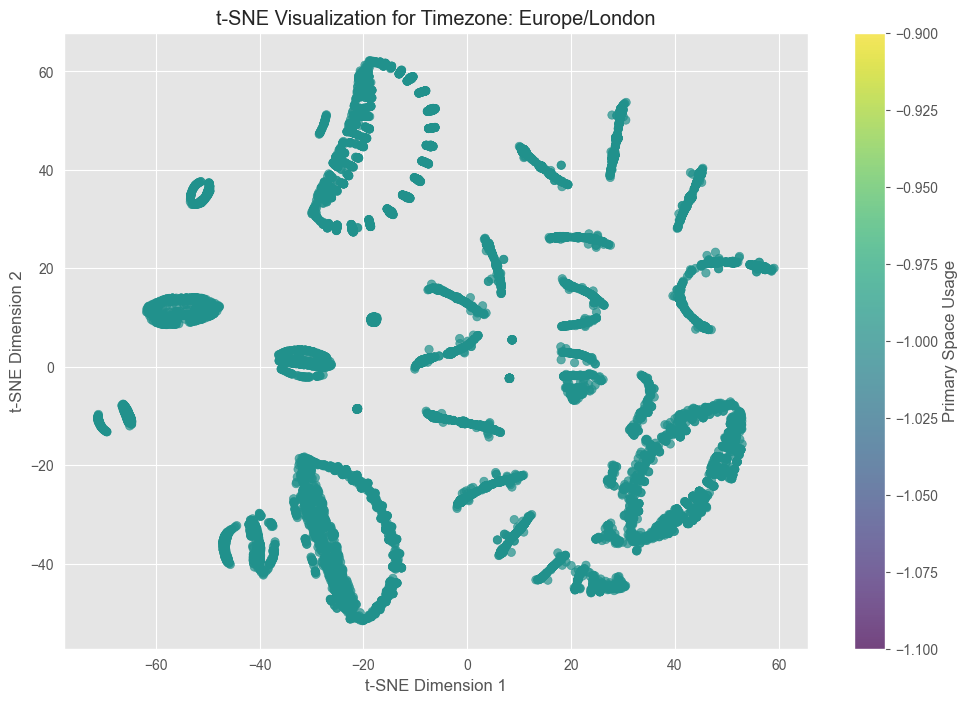

c:\Users\Vitalia\Documents\nosql_lab\Project_python11\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


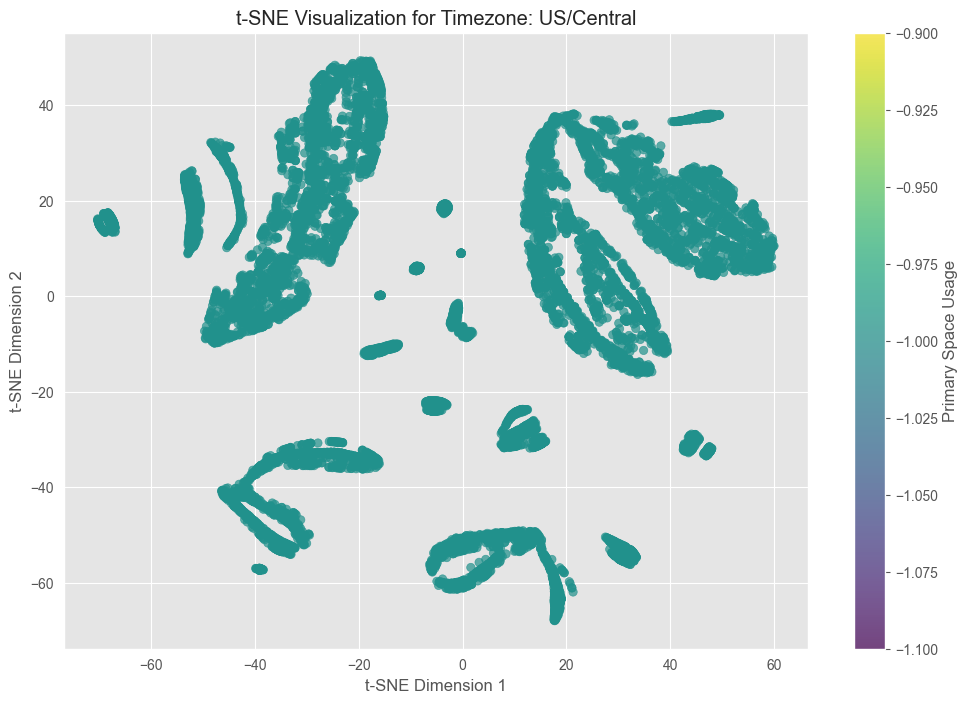

c:\Users\Vitalia\Documents\nosql_lab\Project_python11\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


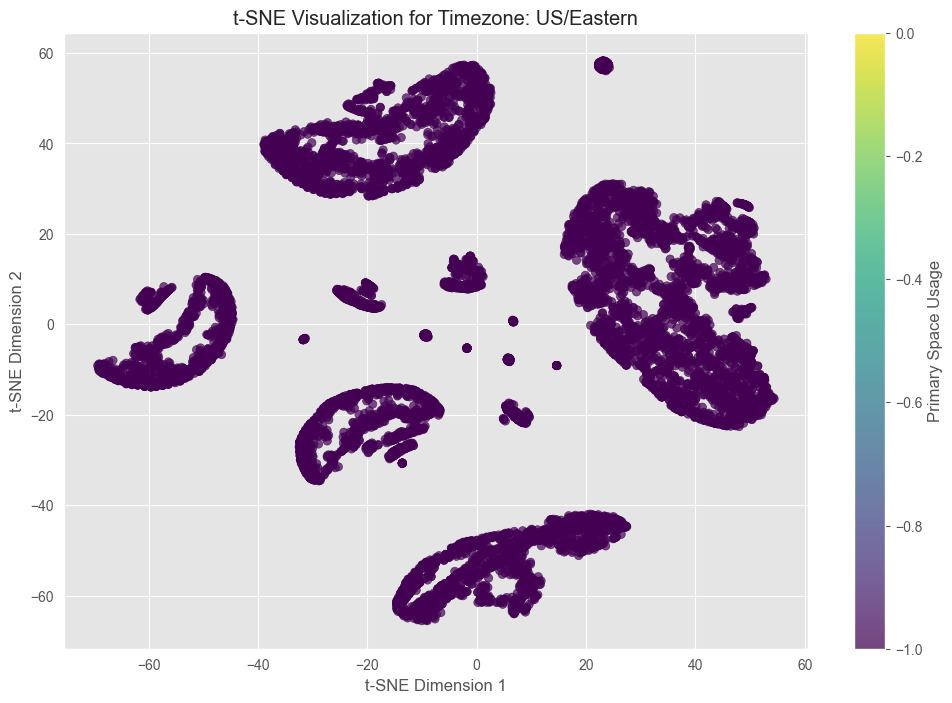

c:\Users\Vitalia\Documents\nosql_lab\Project_python11\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


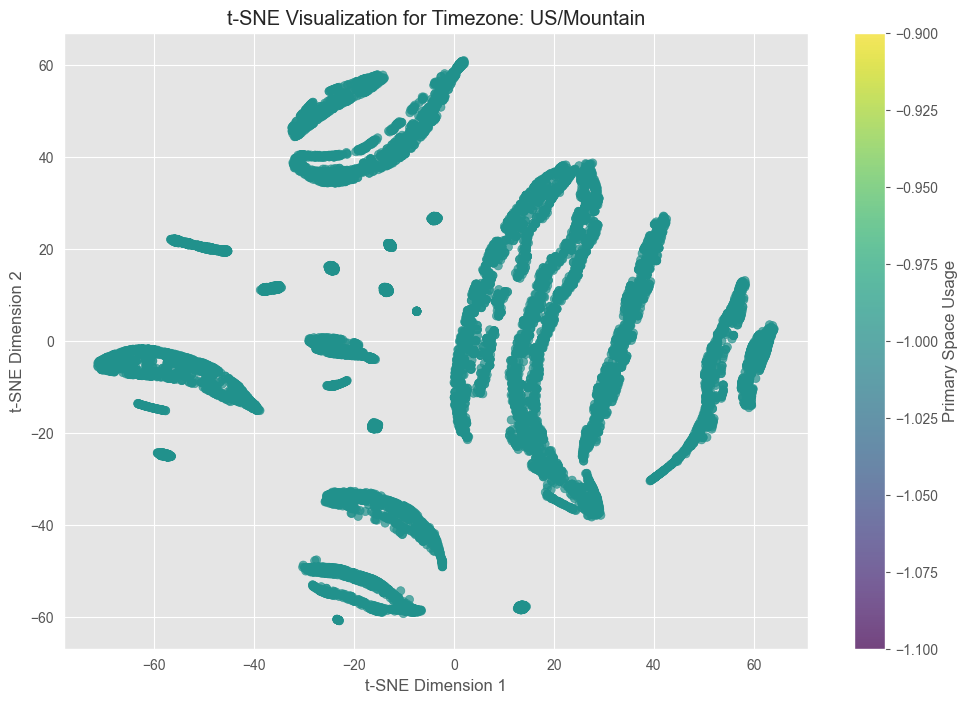

c:\Users\Vitalia\Documents\nosql_lab\Project_python11\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


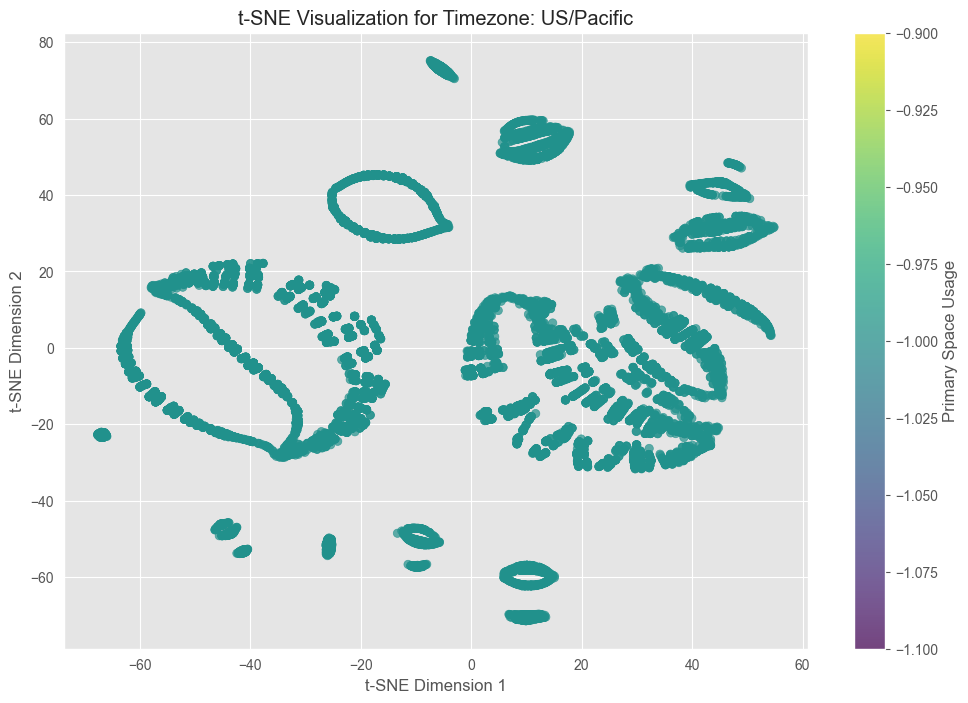

In [19]:
# Sample the data per timezone since the dataset is very large and modeling takes too long otherwise
dev_subset = dev.groupby('timezone', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 10000), random_state=42)
)

dev_subset =  dev_subset[["primaryspaceusage", "meter_reading", "timestamp", "timezone", "sqm", "airTemperature"]]

# Fill NaN values in numeric columns with the median
numeric_columns = ['meter_reading', 'airTemperature', "sqm"]
median_values = dev_subset[numeric_columns].median()
dev_subset[numeric_columns] = dev_subset[numeric_columns].fillna(median_values)

# One-hot encode 'primaryspaceusage'
dev_encoded = pd.get_dummies(dev_subset, columns=['primaryspaceusage'], drop_first=False)

# Normalize the numeric columns
scaler = MinMaxScaler()
dev_encoded[numeric_columns] = scaler.fit_transform(dev_encoded[numeric_columns])

# Group the data by 'timezone' and apply t-SNE separately for each timezone
for timezone, group in dev_encoded.groupby('timezone'):
    # Apply t-SNE for the current timezone
    tsne = TSNE(n_components=2, random_state=42, perplexity=100, n_iter=1000)
    
    # Select the relevant features for t-SNE: numeric columns and one-hot encoded 'primaryspaceusage'
    columns_for_tsne = numeric_columns + list(dev_encoded.filter(like='primaryspaceusage_').columns)
    
    # Apply t-SNE transformation
    tsne_result = tsne.fit_transform(group[columns_for_tsne])
    
    # Create a DataFrame for the current timezone with the t-SNE results
    tsne_df = pd.DataFrame(tsne_result, columns=['tsne_dim_1', 'tsne_dim_2'])
    tsne_df['timezone'] = timezone
    
    # Use the one-hot encoded 'primaryspaceusage' column, assuming only one primary space usage category is applicable
    primaryspaceusage_columns = list(dev_encoded.filter(like='primaryspaceusage_').columns)
    tsne_df['primaryspaceusage'] = group[primaryspaceusage_columns].idxmax(axis=1).str.replace('primaryspaceusage_', '')  # Extract the category
    
    # Plot the t-SNE result for the current timezone
    plt.figure(figsize=(12, 8))
    
    # Scatter plot with coloring based on 'primaryspaceusage'
    plt.scatter(tsne_df['tsne_dim_1'], tsne_df['tsne_dim_2'], 
                c=pd.factorize(tsne_df['primaryspaceusage'])[0], cmap='viridis', alpha=0.7)
    
    # Add labels and title
    plt.colorbar(label='Primary Space Usage')
    plt.title(f't-SNE Visualization for Timezone: {timezone}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()